# TP 3 - Planning (November 30)


![ChessUrl](https://gymnasium.farama.org/_images/frozen_lake.gif "Frozen Lake")

In this assignement, we focus on algorithms that require a **model** of the environment behavior. You will implement :

- A Monte Carlo Tree Search Algorithm
- A Tabular Dyna-Q Algorithm

You will be evaluated on:
* Implementation of the agents. Points will be granted to clean, scalable code.
* A Paragraph of analysis of the behavior of the algorithms . 

Send this notebook  to cyriaque.rousselot@inria.fr before next course.


In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils

## Environment

### Snapshots

For the sake of planning algorithm, we will introduce the possibility of taking snapshots of the environment. Snapshots allows to return to a previously visited state.

In [2]:
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

import gymnasium as gym

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from IPython.display import Image, display

In [3]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200, is_slippery=False))
env.reset()
n_actions = env.action_space.n
n_states = env.observation_space.n

In [4]:
print("initial_state:")
print(env.render())
# plt.axis('off')
env.close()

# create first snapshot
snap0 = env.get_snapshot()

initial_state:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [5]:
while True:
    _, _, terminated, truncated, _ = env.step(env.action_space.sample())
    if terminated:
        print("Whoops! We died!")
        break
    if truncated:
        print("Time is over!")
        break

print("final state:")
print(env.render())
env.close()

Whoops! We died!
final state:
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [6]:
# reload initial state
env.load_snapshot(snap0)

print("After loading snapshot")
print(env.render())
env.close()

After loading snapshot

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



## Monte Carlo Tree Search

https://en.wikipedia.org/wiki/Monte_Carlo_tree_search ; Sutton-Barto Chapter 8.11

The MCTS algorithm we will implement can be divided in 4 steps:
- Selection 
- Expansion
- Simulation
- Backpropagation

The first step is exploring the current tree using a UCB-1 rule until we get to a leaf L .

The second is creating a child C from feasable moves after the leaf L if the game is not finished.

The third is simulating the end of the game with an unbiased method to get an estimate of the value of the position C.

The fourth is updating the value estimation of the position of all nodes visited during the exploration of the tree.



![image.png](https://i.postimg.cc/6QmwnjPS/image.png)

We will use snapshots to simulate the effect of a sample model:
1. Saving a snapshot of state S
2. sending S,A to the environement
3. Getting back R and S'
4. When needed, loading the snapshot of state S

## Building the agent:

> Fill the blanks in the code

In [7]:
class BaseNode(ABC):
    """A general node in the Monte Carlo Tree Search (MCTS) algorithm. 
    It will serve as a base class for the MCTS nodes for different environments."""

    parent = None
    qvalue_sum = 0.
    times_visited = 0

    def __init__(self, parent, action):
        self.parent = parent
        self.action = action
        self.children = []

        result = env.get_result(parent.snapshot, action)
        (
            self.snapshot,
            self.observation,
            self.immediate_reward,
            self.is_done,
            _,
            _
        ) = result

    def is_leaf(self):
        return not self.children

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self):
        if self.times_visited != 0:
            return self.qvalue_sum / self.times_visited
        return 0

    def ucb_score(self, scale=2, max_value=float("inf")):
        if self.times_visited == 0:
            return max_value

        mu = self.get_qvalue_estimate()
        t = self.parent.times_visited
        n = self.times_visited
        return mu + scale * np.sqrt(np.log(t) / n)

    def select_best_child(self):
        children_scores = [child.ucb_score() for child in self.children]
        best_score = np.argmax(children_scores)
        return self.children[best_score]

    def select_best_leaf(self):
        if self.is_leaf():
            return self
        return self.select_best_child().select_best_leaf()

    @abstractmethod
    def expand(self):
        """Expand method must be implemented in subclass"""
        pass

    def rollout(self, t_max=1000):
        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done

        if is_done:
            return self.immediate_reward

        rollout_reward = 0
        t = 0
        while not is_done and t<t_max:
            action = env.action_space.sample() # random rollout policy
            obs, reward, is_done, truncated, _ = env.step(action)
            rollout_reward += reward
            t += 1
            
        return rollout_reward

    def propagate(self, child_qvalue):
        my_qvalue = self.immediate_reward + child_qvalue
        self.qvalue_sum += my_qvalue
        self.times_visited += 1
        if not self.is_root():
            self.parent.propagate(my_qvalue)

    def safe_delete(self):
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

    def __str__(self):
        return f"{self.observation}\nq:{self.get_qvalue_estimate():.3f}"

    def __repr__(self):
        return self.__str__()


In [8]:
class Root(BaseNode):
    """The root node"""

    def __init__(self, snapshot, observation):
        self.parent = self.action = None
        self.children = []
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False

    @classmethod
    def from_node(cls, node):
        root = cls(node.snapshot, node.observation)
        # Copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

In [9]:
class FrozenLakeNode(BaseNode):
    """Node for the FrozenLake environment"""

    action_dict = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}

    def __init__(self, parent, action):
        super().__init__(parent, action)
        self.depth = parent.depth + 1

    def expand(self):
        """
        Expands the current node by creating all possible child nodes that make sense. Two constraints are applied:
            1. You can't generate a child with an action that would get out of the board.
            2. You can't generate a child with the opposite action of the parent (e.g. parent action = LEFT, child action = RIGHT)
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"

        x = self.observation//8
        y = self.observation%8

        actions = [0,1,2,3]

        if x == 0:
            actions.remove(3)
        elif x == 7:
            actions.remove(1)
        if y == 0:
            actions.remove(0)
        elif y == 7:
            actions.remove(2)

        if self.action is not None:
            if (self.action == 0) and (2 in actions):
                actions.remove(2)
            elif (self.action == 1) and (3 in actions):
                actions.remove(3)
            elif (self.action == 2) and (0 in actions):
                actions.remove(0)
            elif (self.action == 3) and (1 in actions):
                actions.remove(1)

        self.children = [FrozenLakeNode(self, action) for action in actions]

        return self.select_best_leaf()
    
    def print_policy(self):
        if self.is_root():
            print("root")
        else:
            print("action: ", self.action_dict[self.action], " qvalue estimate: ", self.get_qvalue_estimate())
        
        if not self.is_leaf():
            best_child = self.select_best_child()
            best_child.print_policy()

    def count_nodes(self):
        if self.is_leaf():
            return 1
        else:
            return 1 + sum(child.count_nodes() for child in self.children)
        
    def get_max_depth(self):
        if self.is_leaf():
            return 1
        else:
            return 1 + max(child.get_max_depth() for child in self.children)

    def get_observations(self):
        if self.is_leaf():
            return [self.observation]
        
        else:
            return [self.observation] + [obs for child in self.children for obs in child.get_observations()]

    def __str__(self) -> str:
        x = self.observation//8
        y = self.observation%8
        return f"{x},{y}\nq:{self.get_qvalue_estimate():.3f}"

    def __repr__(self) -> str:
        return self.__str__()

In [10]:
class FrozenLakeRoot(Root, FrozenLakeNode):  
    """The root node for the FrozenLake environment"""

    def __init__(self, snapshot, observation):
        super().__init__(snapshot, observation)
        self.depth = 0
        
    def plot_node_counts(self):
        grid = np.zeros((8,8))
        positions, counts = np.unique(self.get_observations(), return_counts=True)
        xx = positions//8
        yy = positions%8
        grid[xx, yy] = counts

        plt.imshow(grid, cmap='viridis')
        for i in range(8):
            for j in range(8):
                plt.text(j, i, grid[i, j],
                        ha="center", va="center", color="w")
        plt.xlabel("y")
        plt.ylabel("x")

In [11]:
def plan_mcts(root, n_iters=10):
    """
    Builds a tree with Monte-Carlo Tree Search for n_iters iterations.
    :param root: Tree node to plan from.
    :param n_iters: Number of select-expand-simulate-propagate loops to make.
    """
    for _ in range(n_iters):
        node = root.select_best_leaf()

        if node.is_done:
            node.propagate(0)
        else:
            node = node.expand()
            rollout_reward = node.rollout()
            node.propagate(rollout_reward)

### Running the MCTS 

In [12]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200,
                             is_slippery=False))
root_observation, _ = env.reset()
root_snapshot = env.get_snapshot()
root = FrozenLakeRoot(root_snapshot, root_observation)

> Use the MCTS implementation to find the optimal policy and show it. Bonus point will be given to a clear display

I tried running the algorithm with a lower number of iterations but it wasn't able to get to the target, which made all the q-values zero, and didn't allow the model to learn properly. With enough iterations, 10k, it is able to get to the target and propagate this information to the previous nodes, so that the optimal path is found.

In [13]:
plan_mcts(root, n_iters=10000)

Nonetheless, many nodes are created unnecessarily, as they represent paths that are coming back to the origin or circling around. As seen in the two next cells, around 10000 nodes are created with a maximum depth of 17, even though the solution has only 14 steps.

In [14]:
root.count_nodes()

11670

In [15]:
root.get_max_depth()

17

This can be illustrated better in the following plot, which shows how many nodes are created in the tree representing each position in the board. For instance, 275 nodes are created for the starting position, which means that there are 275 paths in the tree that come back to the start. The most repeated position is (2, 3) with more than 500 nodes (this number can vary depending on the randomness of the algorithm).

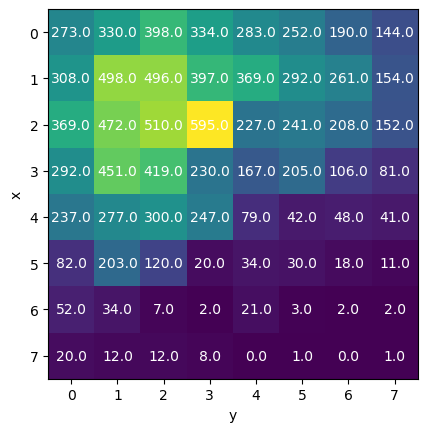

In [16]:
root.plot_node_counts()

The found policy can be seen below, along with the q-values of the chosen nodes at each step. As we get closer to the target, the q-values increase monotonically, until they reach the value of 1. 

In [17]:
root.print_policy()

root
action:  RIGHT  qvalue estimate:  0.3264222922541052
action:  RIGHT  qvalue estimate:  0.48257241040746196
action:  RIGHT  qvalue estimate:  0.6422258592471358
action:  RIGHT  qvalue estimate:  0.7649122807017544
action:  RIGHT  qvalue estimate:  0.8464193270060397
action:  RIGHT  qvalue estimate:  0.8962522851919561
action:  RIGHT  qvalue estimate:  0.9228235294117647
action:  DOWN  qvalue estimate:  0.9228235294117647
action:  DOWN  qvalue estimate:  0.937799043062201
action:  DOWN  qvalue estimate:  0.950509461426492
action:  DOWN  qvalue estimate:  0.9626535626535626
action:  DOWN  qvalue estimate:  0.9751119960179193
action:  DOWN  qvalue estimate:  0.9873991935483871
action:  DOWN  qvalue estimate:  1.0


In [18]:
G = nx.DiGraph()

def add_node_to_graph(node, add_children=True):
    label = f"Q: {node.get_qvalue_estimate():.2f}\nVisits: {node.times_visited}"
    G.add_node(node, label=label)
    if node.parent:
        action_label = f"Action: {node.action_dict[node.action]}"
        G.add_edge(node.parent, node, label=action_label)
    
    if node.children and add_children:
        children_scores = [child.ucb_score() for child in node.children]
        best_ix = np.argmax(children_scores)

        for i, child in enumerate(node.children):
            add_children = i == best_ix
            add_node_to_graph(child, add_children=add_children)

In [19]:
add_node_to_graph(root)

I also show the policy as a graph, comparing at each time the q-value of the chosen action with respect to the other possible options. In this case most nodes only have 2 children because they are next to the edge of the board. There is even one node with only one child, which corresponds to the upper-right corner of the board, or position (0,7). Notice that this is just a very small fraction of the entire graph that was generated during training, which would be impossible to plot (I tried).

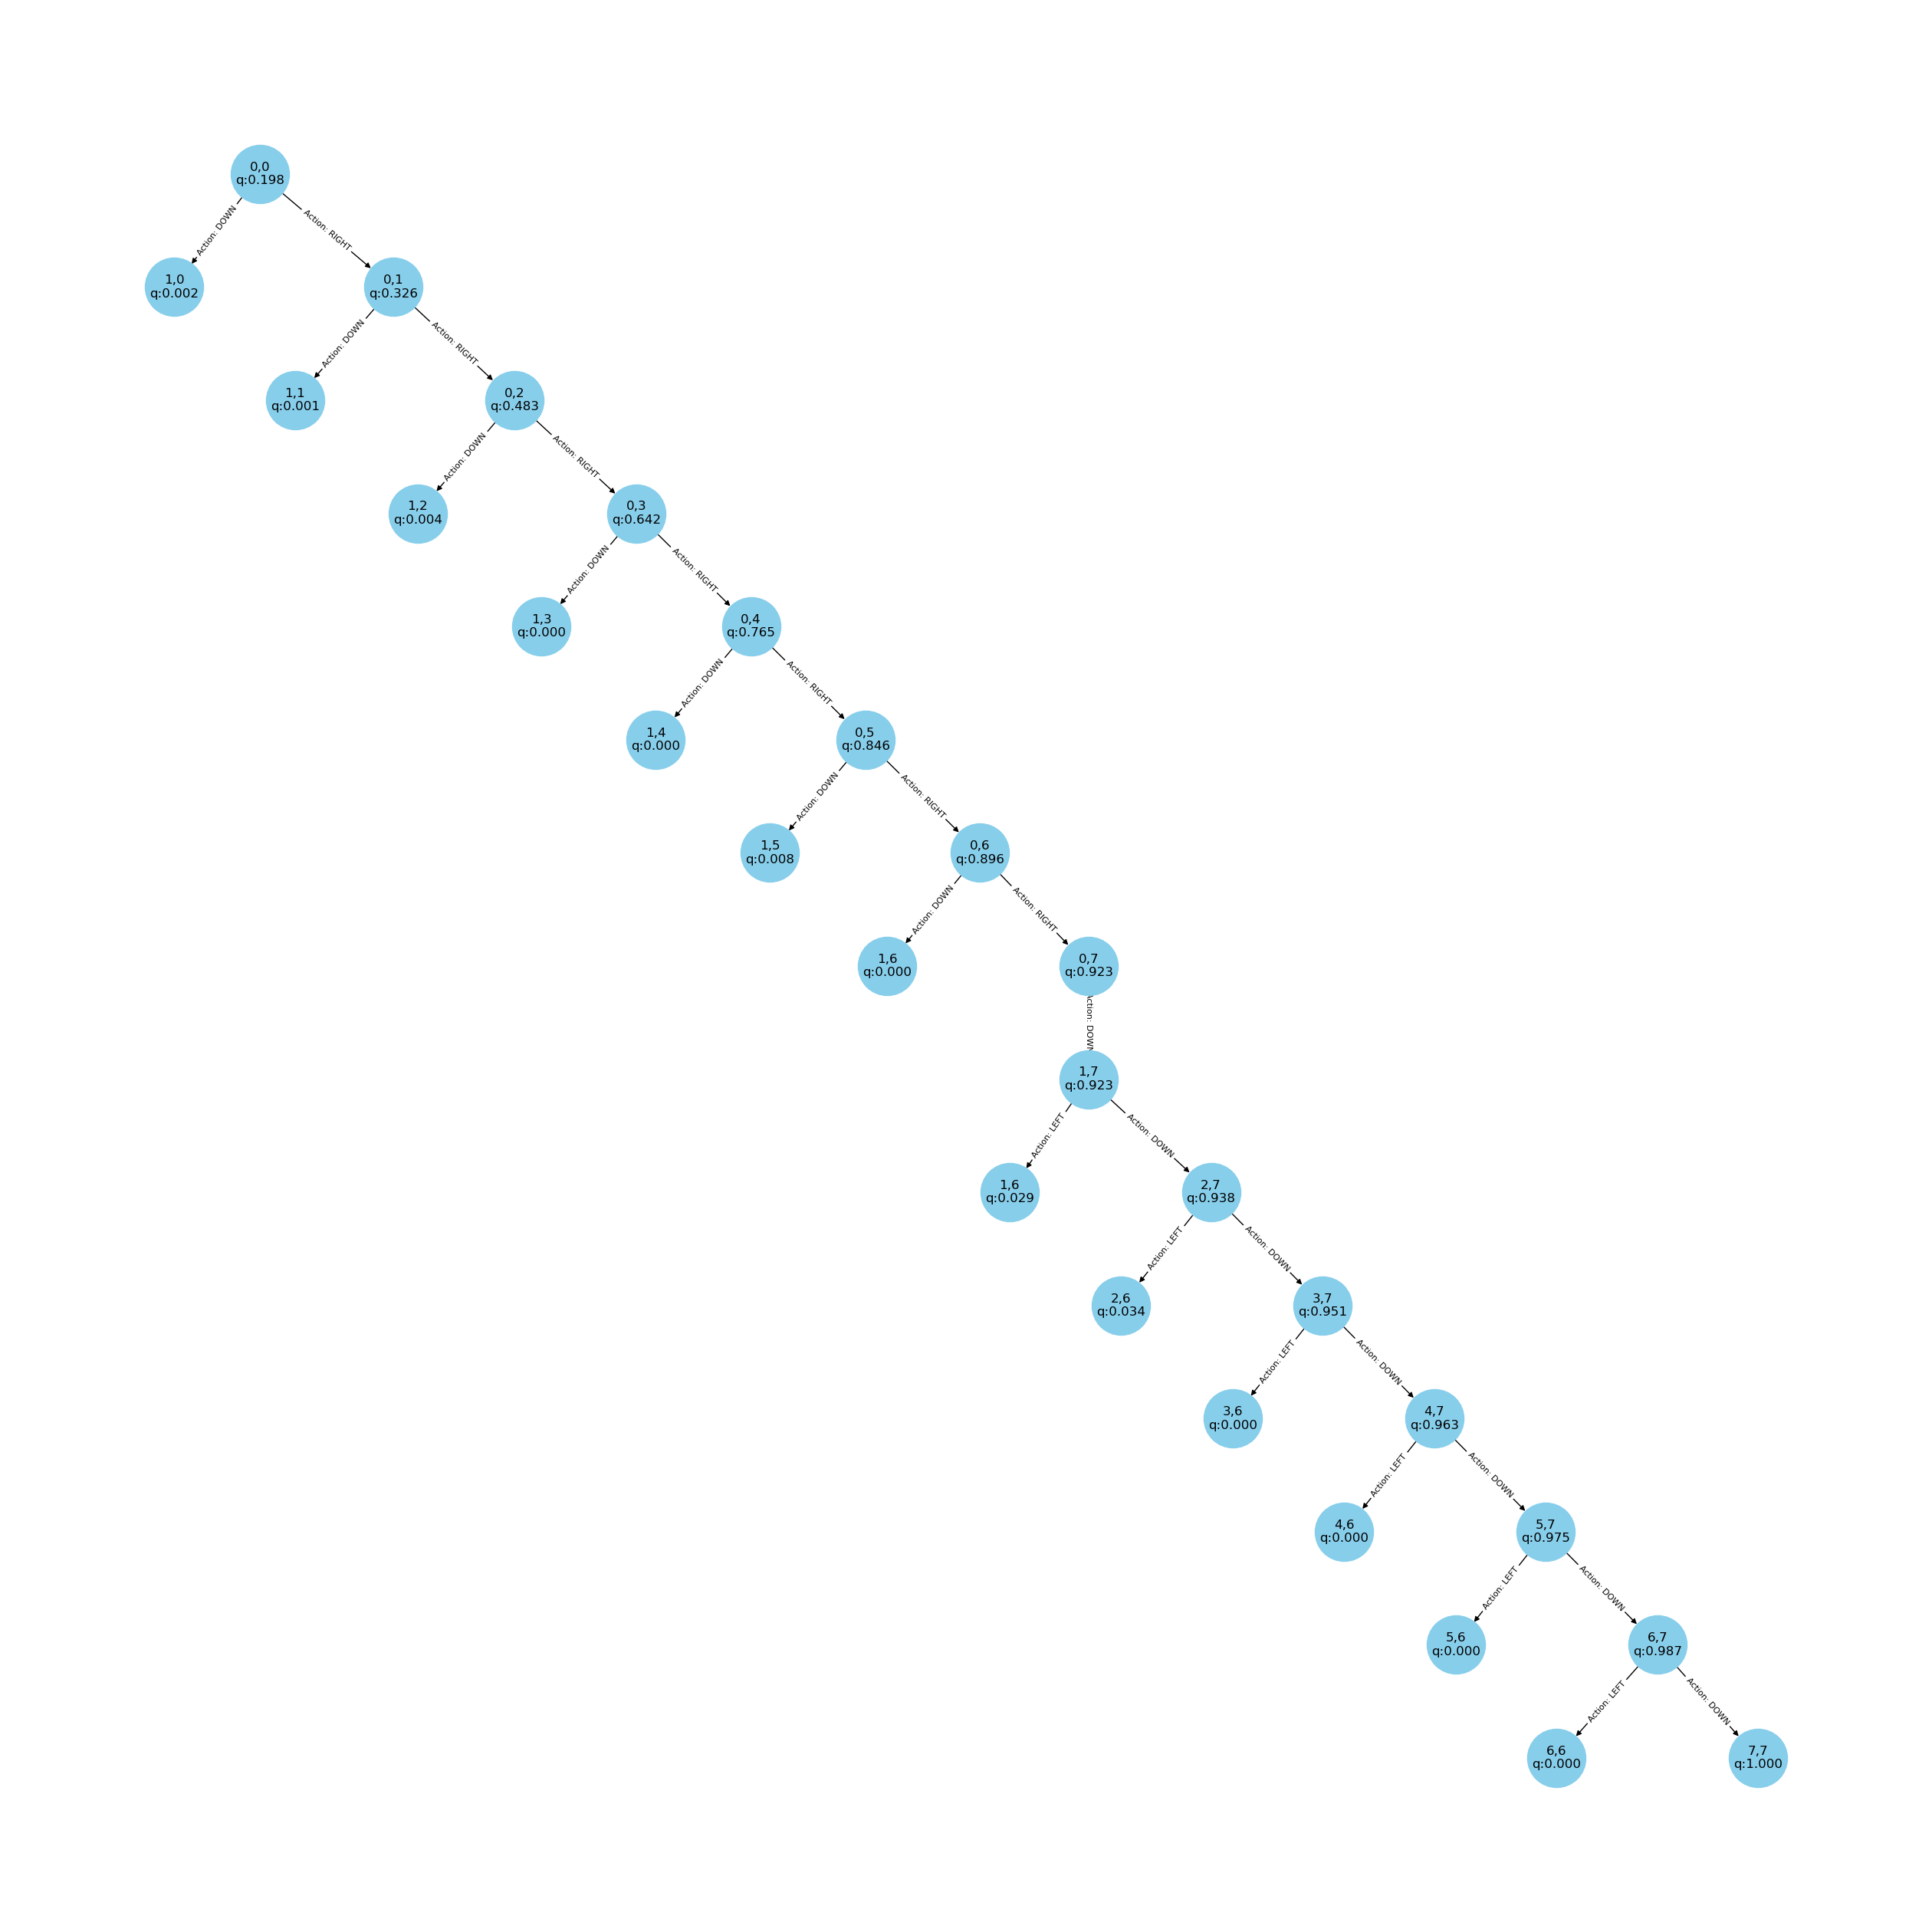

In [20]:
plt.figure(figsize=(25, 25))
pos = graphviz_layout(G, prog="dot",) 
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue",)
edge_labels = nx.get_edge_attributes(G, 'label', )
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.show()

> Try it also on the Cartpole problem:

In [21]:
class CartPoleNode(BaseNode):
    """Node for the CartPole environment"""

    action_dict = {0: "LEFT", 1: "RIGHT"}

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.

        Returns one of those children.
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"

        actions = [0, 1]

        self.children = [CartPoleNode(self, action) for action in actions]

        return self.select_best_leaf()

In [22]:
class CartPoleRoot(Root, CartPoleNode):  
    """The root node for the CartPole environment"""

    def __init__(self, snapshot, observation):
        super().__init__(snapshot, observation)

In [23]:
env = utils.WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=300))

In [24]:
root_observation, _ = env.reset()
root_snapshot = env.get_snapshot()
root = CartPoleRoot(root_snapshot, root_observation)

Generally this agent is able to keep the cart and pole within the allowed limits for over 200 iterations. For more iterations it usually gets outside of the map edges with the cart, as it tries to balance a falling pole with a lot of movement in one direction. For instance, if the pole is falling to the right, it will try to go in that direction. This likely comes from the number of iterations and the low number of rollout steps due to the truncation of the game. As such, the model is able to see that letting the pole fall is bad, but it does not reach the point of seeing that going outside the map borders is also bad.

In [25]:
def play_cart_pole(root, force_continue=False):
    images = []
    data = []
    choices = []
    for n in range(5000):
        plan_mcts(root, n_iters=10) # simulate 10 steps 
        env.load_snapshot(root.snapshot) # reset the environment to the root state
        action = root.select_best_child().action # select the best action to take from the root
        root = CartPoleRoot.from_node(root.children[action]) # move the root node to the child corresponding to the action
        state, reward, done, truncated, _ = env.step(action) # take the action
        data.append(state) # save the state
        images.append(env.render()) # save the image
        choices.append(action) # save the action
        if force_continue:
            if done or truncated:
                root_observation, _ = env.reset()
                root_snapshot = env.get_snapshot()
                root = CartPoleRoot(root_snapshot, root_observation)
        else:
            if done:
                print('done')
                print('iter', n+1)
                break
            if truncated and not force_continue:
                print('time is over')
                break

    return images, data, choices

In [26]:
images, data, _ = play_cart_pole(root, force_continue=False)

time is over


In [27]:
data = np.array(data)

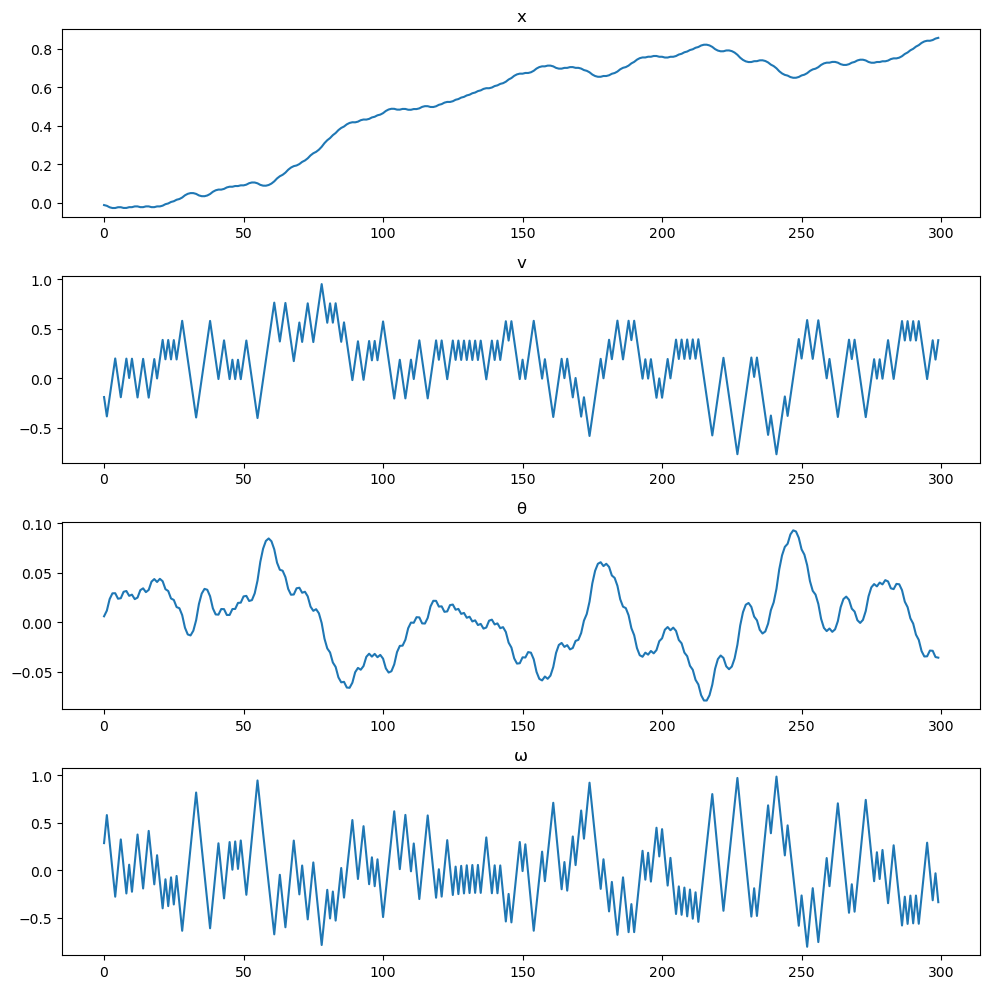

In [28]:
data_names = ['x', 'v', '\u03b8', '\u03c9']
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for i in range(4):
    axs[i].plot(data[:, i])
    axs[i].set_title(f"{data_names[i]}")

plt.tight_layout()

In [29]:
for i, img in enumerate(images):
    text = f"Iteration: {i+1}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    position = (10, 50) 
    font_scale = 1
    font_color = (255, 0, 0)
    line_type = 2

    img_with_text = cv2.putText(img.copy(), text, position, font, font_scale, font_color, line_type)
    images[i] = img_with_text

In [30]:
gif_path = './animation.gif'
imageio.mimsave(gif_path, images, fps=10)

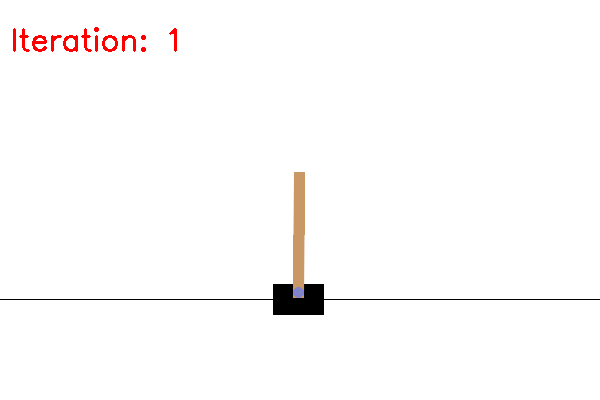

In [31]:
display(Image(filename=gif_path))

## (BONUS) Introducing some Machine Learning

Planning on each iteration can be costly. You can speed things up drastically if you train a classifier to predict which action will turn out to be best according to MCTS.

>To do so, adapt the code and record which action did the MCTS agent take on each step and fit a classifier to [state, mcts_optimal_action]

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [33]:
env = utils.WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200))

I record many different iterations of the game with MCTS and fit a logistic regression and random forest classifiers on the moves made by the algorithm.

In [34]:
_, data, labels = play_cart_pole(root, force_continue=True)

In [35]:
data = np.array(data)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [37]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([2534, 2466]))

Both ML get around 70% accuracy to predict the moves of MCTS.

In [38]:
logistic = LogisticRegression().fit(X_train, y_train)
print(f"Train accuracy: {logistic.score(X_train, y_train)}")
print(f"Test accuracy: {logistic.score(X_test, y_test)}")

Train accuracy: 0.70075
Test accuracy: 0.724


In [39]:
forest = RandomForestClassifier(max_depth=4, n_estimators=200).fit(X_train, y_train)
print(f"Train accuracy: {forest.score(X_train, y_train)}")
print(f"Test accuracy: {forest.score(X_test, y_test)}")

Train accuracy: 0.7145
Test accuracy: 0.731


Unfortunately, these models on their own are very poor, surviving in the game for around 9 iterations. Their problem is the same as the original MCTS, but it gets amplified. They try to always go in the same direction, which makes the pole get out of the permitted boundaries.

In [40]:
state, _ = env.reset()

for n in range(500):
    action = logistic.predict([state])[0]
    model_prob = logistic.predict_proba([state])[0][action]
    state, reward, done, truncated, _ = env.step(action)
    print('Action: {}, Prob: {:.2f}, State: {}'.format(action, model_prob , state))
    if done:
        print('done, we lost :( at iter', n+1)
        break
    if truncated:
        print('time is over')
        break

Action: 1, Prob: 0.56, State: [ 0.02518729  0.21304491  0.03228717 -0.28627032]
Action: 1, Prob: 0.73, State: [ 0.02944818  0.4076919   0.02656177 -0.5685978 ]
Action: 1, Prob: 0.85, State: [ 0.03760202  0.6024314   0.01518981 -0.85279584]
Action: 1, Prob: 0.92, State: [ 0.04965065  0.797343   -0.00186611 -1.1406639 ]
Action: 1, Prob: 0.96, State: [ 0.06559751  0.99248934 -0.02467939 -1.4339315 ]
Action: 1, Prob: 0.98, State: [ 0.0854473   1.1879069  -0.05335801 -1.7342235 ]
Action: 1, Prob: 0.99, State: [ 0.10920543  1.3835953  -0.08804248 -2.0430183 ]
Action: 1, Prob: 0.99, State: [ 0.13687734  1.5795046  -0.12890285 -2.361595  ]
Action: 1, Prob: 1.00, State: [ 0.16846743  1.7755183  -0.17613475 -2.690969  ]
Action: 1, Prob: 1.00, State: [ 0.2039778   1.9714364  -0.22995412 -3.0318155 ]
done, we lost :( at iter 10


# Model Learning:  Dyna-Q

> Implement a Tabular Dyna-Q algorithm ( Chapter 8.2 Barto-Sutton) for the Frozen Lake environment

!["Description of Dyna Algorithm"](dyna.png)

In [41]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                                render_mode="ansi",
                                max_episode_steps=200, is_slippery=False))

In [42]:
class DynaAgent:
    alpha = 0.1
    gamma = 0.9
    
    def __init__(self, env, epsilon=1e-3):
        self.n_actions = env.action_space.n
        self.n_states = env.observation_space.n
        self.epsilon = epsilon
        self.q = np.zeros((n_states,n_actions))
        self.model = np.zeros((n_states,n_actions,2)) # self.model[s,a] return r and s'
        self.env = env
        self.current_state,_ = env.reset()
        self.explored_states = {self.current_state: set()}

    def choose(self):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action_values = self.q[self.current_state, :]
            best_actions = np.where(action_values == np.max(action_values))[0]
            action = np.random.choice(best_actions)
        self.explored_states[self.current_state].add(action)
        return action
    
    def record_change(self, state):
        self.current_state = state
        if state not in self.explored_states:
            self.explored_states[state] = set()
    
    def update_model(self,s1,a1,r1,s2):
        self.model[s1,a1] = [r1,s2]

    def update_value(self,s1,a1,r1,s2):
        self.q[s1,a1] = self.q[s1, a1] + self.alpha*(r1 + self.gamma*np.max(self.q[int(s2),:]) - self.q[s1,a1])

    def planning(self,n_steps):
        for _ in range(n_steps):
            s1 = np.random.choice(list(self.explored_states.keys()))
            actions_taken = self.explored_states[s1]
            if len(actions_taken) == 0:
                continue
            a1 = np.random.choice(list(actions_taken))
            r1, s2 = self.model[s1,a1]
            self.update_value(s1,a1,r1,s2)

In [43]:
agent = DynaAgent(env)

In [44]:
def play_dyna(agent, n_steps=1000, planning_steps=50):
    for _ in range(n_steps):
        action = agent.choose()
        state, reward, done, truncated, _ = env.step(action)
        agent.update_value(agent.current_state, action, reward, state)
        agent.update_model(agent.current_state, action, reward, state)
        agent.record_change(state)
        agent.planning(planning_steps)

        if done:
            state, _ = env.reset()
            agent.record_change(state)

In [45]:
play_dyna(agent)

In [46]:
agent.explored_states

{0: {0, 1, 2, 3},
 1: {0, 1, 2, 3},
 9: {0, 1, 2, 3},
 8: {0, 1, 2, 3},
 16: {0, 1, 2, 3},
 24: {0, 1, 2, 3},
 32: {0, 1, 2, 3},
 40: {0, 1, 2},
 41: set(),
 17: {0, 1, 2, 3},
 18: {0, 1, 2, 3},
 19: set(),
 2: {0, 1, 2, 3},
 48: {1, 3},
 33: {0, 1, 2, 3},
 10: {0, 1, 2, 3},
 11: {0, 1, 2, 3},
 3: {0, 1, 2, 3},
 25: {0, 1, 2, 3},
 4: {0, 1, 2, 3},
 12: {0, 1, 2, 3},
 5: {0, 1, 2, 3},
 13: {1, 2, 3},
 14: {0, 1, 2, 3},
 22: {1, 2, 3},
 23: {0, 1, 2, 3},
 31: {0, 1, 2, 3},
 30: {0, 1, 2, 3},
 39: {0, 2, 3},
 38: {0, 1, 3},
 6: {0, 1, 2, 3},
 7: {1, 2, 3},
 15: {0, 1, 2, 3},
 29: set(),
 26: {0, 1, 2, 3},
 27: {0, 2, 3},
 28: {2},
 46: set(),
 34: {1, 2},
 42: set(),
 37: {1},
 45: {2},
 35: set(),
 56: {1, 2},
 57: {0, 1, 3},
 49: set(),
 20: {0},
 21: {0}}

In [47]:
visits = np.zeros((64))
for state, actions in agent.explored_states.items():
    visits[state] = len(actions)

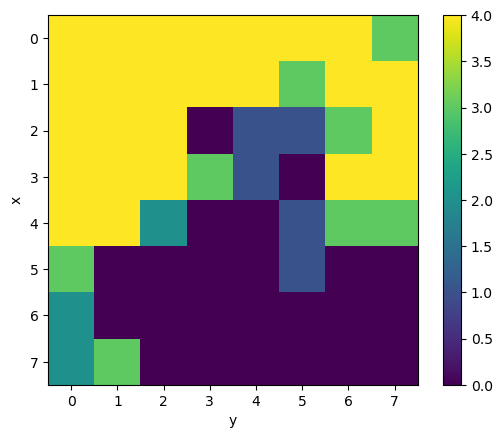

In [48]:
plt.imshow(visits.reshape(8,8), cmap='viridis')
plt.colorbar()
plt.xlabel("y")
plt.ylabel("x")
plt.show()

In [49]:
np.unique(agent.q, return_counts=True)

(array([0.]), array([256]))

In [50]:
63 in agent.explored_states

False

> What are some limits of the algorithm ? Does it scale ? Explain. 

As can be seen above, this agent suffers from the low amount of signal in the environment. It does not have a way to detecting the good directions unless it gets to the target, which would allow him to update its q-value function and start learning. Instead, it gets lost visiting the nearby areas, without ever updating the q-value and thinking that all choices are the same. Therefore, we can infer that this agent won't scale very well for similar environments of larger sizes.

In [51]:
agent = DynaAgent(env)

play_dyna(agent, n_steps=5000, planning_steps=100)

In [52]:
63 in agent.explored_states

True

In [53]:
def get_policy(q):
    return np.argmax(q, axis=1)

In [54]:
policy = get_policy(agent.q).reshape(8,8)

In [55]:
actions = list('←↓→↑')

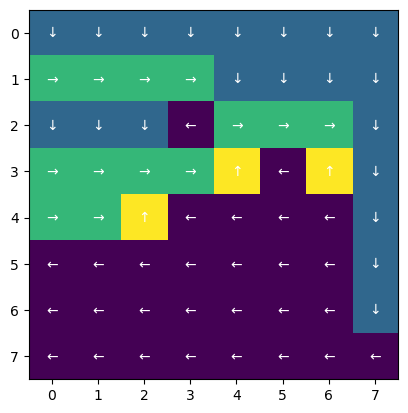

In [56]:
plt.imshow(policy, cmap='viridis')
for i in range(8):
    for j in range(8):
        plt.text(j, i, actions[policy[i, j]],
                ha="center", va="center", color="w")

We can see that with many planning steps, the agent is able to find a good policy.

_Parts of the code for this practical has been inspired by https://github.com/yandexdataschool/Practical_RL/_